In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

In [2]:
dartFrame = cv2.imread('darts.jpg')
emptyFrame = cv2.imread('empty.jpg')

gray_dart = cv2.cvtColor(dartFrame, cv2.COLOR_BGR2GRAY)
gray_empty = cv2.cvtColor(emptyFrame, cv2.COLOR_BGR2GRAY)

gray_dart_median = cv2.medianBlur(gray_dart,5)
gray_empty_median = cv2.medianBlur(gray_empty,5)

In [ ]:
#My Mask
import math

difference_gray = cv2.add(cv2.subtract(gray_dart_median, gray_empty_median),cv2.subtract(gray_empty_median, gray_dart_median))

_, threshhold_image = cv2.threshold(difference_gray, 130, 255, cv2.THRESH_BINARY)
# contours, _ = cv2.findContours(threshhold_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# mask_janosch = np.zeros_like(threshhold_image)
# min_area = 80

# for contour in contours:
#     if cv2.contourArea(contour) > min_area:
#         cv2.drawContours(mask_janosch, [contour], -1, (255), thickness=cv2.FILLED)

#Ollie Mask
def reduce_brightness(image, factor):
    if factor < 0 or factor > 255:
        raise ValueError("Factor must be between 0 and 255.")
    reduced_image = image.astype(np.int16) - factor
    return np.clip(reduced_image, 0, 255).astype(np.uint8)
 
brightness_factor = 75
empty_dartboard_dark = reduce_brightness(emptyFrame, brightness_factor)
dartboard_with_darts_dark = reduce_brightness(dartFrame, brightness_factor)
 
empty_gray = cv2.cvtColor(empty_dartboard_dark, cv2.COLOR_BGR2GRAY)
darts_gray = cv2.cvtColor(dartboard_with_darts_dark, cv2.COLOR_BGR2GRAY)
 
difference = cv2.absdiff(empty_gray, darts_gray) 
 
_, mask = cv2.threshold(difference, 40, 255, cv2.THRESH_BINARY)
 
kernel = np.ones((4, 4), np.uint8) 
mask_eroded = cv2.erode(mask, kernel, iterations=1)

#Find Centerpoints in Contours of Mask
contours_in_mask, _ = cv2.findContours(mask_eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area_threshold = 50
centroids = []

for contour_mask in contours_in_mask:
    area = cv2.contourArea(contour_mask)
    
    if area > min_area_threshold:
        #Append Highgest Point
        topmost_point = min(contour_mask, key=lambda point: point[0][1])  
        cx, cy = topmost_point[0]
        centroids.append((cx, cy))
        #Append Centerpoints
        M = cv2.moments(contour_mask)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroids.append((cx, cy))

mask2 = np.zeros_like(threshhold_image)

for (cx, cy) in centroids:
    cv2.circle(mask2, (cx, cy), 5, (255, 0, 0), -1)

#Connect the Dots
threshold = 150
threshhold_quadratic_function = 10
groups = []

def euclidean_distance(point1, point2):
    return math.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)

def includedInCone(point):
    if point[1] >= current_point[1]:
        y_distance = point[1] - current_point[1]
        
        x1 = current_point[0] - threshhold_quadratic_function * math.sqrt(y_distance)  
        x2 = current_point[0] + threshhold_quadratic_function * math.sqrt(y_distance)  
        
        return x1 < point[0] < x2
    return False

while len(centroids) > 0:
    list(sorted(centroids, key=lambda y: y[0]))
    sorted_centroids = centroids[::-1]
    current_point = sorted_centroids[0]
    #Build array containing only points within a cone shap underneath the current_point (highest point available)
    filtered_points = [
    point for point in centroids 
    if includedInCone(point)
    ]
    filtered_points.append(current_point)

    groups.append(filtered_points)

    centroids = [item for item in centroids if item not in filtered_points]

colors = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255)
]

mask3 = np.zeros_like(dartFrame)
for index, group in enumerate(groups):
    color = colors[index % len(colors)] 
    print(group)
    for (cx, cy) in group:
        cv2.circle(mask3, (cx, cy), 5, color, -1)

difference = cv2.cvtColor(difference, cv2.COLOR_GRAY2BGR)
result_image = cv2.add(mask3, difference)

if len(filtered_points) > 0:
    closest_point = None
    min_distance = float('inf')
    for point in filtered_points:
        distance = euclidean_distance(current_point, point)
        if distance <= threshold and distance < min_distance:
            closest_point = point
            min_distance = distance

cv2.imwrite('difference.jpg', difference_gray)
cv2.imwrite('mask1.jpg', mask_eroded)
cv2.imwrite('mask2.jpg', mask2)
cv2.imwrite('mask3.jpg', mask3)
cv2.imwrite('result.jpg', result_image)
plt.imshow(result_image)
plt.show()

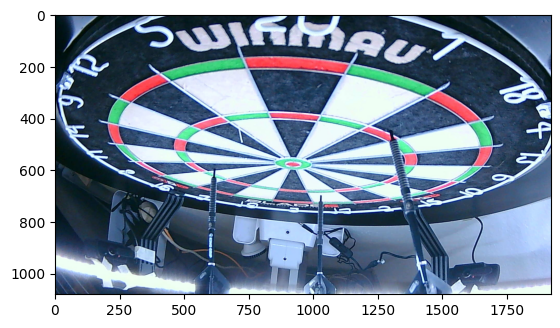

In [4]:
image = cv2.cvtColor(dartFrame, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()